In [58]:
"""
Dedalus script simulating the 1D Korteweg-de Vries / Burgers equation.
This script demonstrates solving a 1D initial value problem and produces
a space-time plot of the solution. It should take just a few seconds to
run (serial only).

We use a Fourier basis to solve the IVP:
    dt(u) + u*dx(u) = a*dx(dx(u)) + b*dx(dx(dx(u)))
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
from matplotlib.animation import FuncAnimation, PillowWriter  
logger = logging.getLogger(__name__)

Number of iterations = 400.0
2022-04-23 19:13:36,138 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 7.0e+01/s
2022-04-23 19:13:36,185 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2022-04-23 19:13:36,234 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2022-04-23 19:13:36,286 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2022-04-23 19:13:36,337 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2022-04-23 19:13:36,386 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2022-04-23 19:13:36,434 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2022-04-23 19:13:36,484 subsystems 0/1 INFO

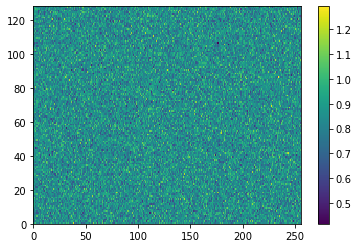

In [128]:
# Parameters
Lx, Ly = 1, 4
Nx,Ny = 128,256
D = 0.25

dealias = 3/2
stop_sim_time = 4
D = 0.25
timestepper = d3.RK111
timestep = .01
dtype = np.float64
alpha = 20.5
r = 1.52

print(f'Number of iterations = {stop_sim_time/timestep}')
# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=dealias)

# Fields
a = dist.Field(name='a', bases=(xbasis,ybasis))
b = dist.Field(name='b', bases=(xbasis,ybasis))

# Substitutions
dx = lambda A: d3.Differentiate(A, coords['x'])

# Problem
problem = d3.IVP([a,b], namespace=locals())
problem.add_equation("dt(a) - D*lap(a)  = r*a*(1-a) - alpha*div(a*grad(b))")
problem.add_equation("dt(b) - lap(b)  = (a/(a+1)-b)")
#problem.add_equation("u(x='left')=0")
#problem.add_equation("u(x='right')=0")

# Initial conditions
x = dist.local_grid(xbasis)
y = dist.local_grid(ybasis)
#print(x)

#n = 20
a_mat = np.random.normal(size=(len(x), len(np.transpose(y))))*0.1 + 0.85
b_mat = np.random.normal(size=(len(x), len(np.transpose(y))))*0.05 + 0.5
centerx = int(len(x)/2)
centery = int(len(np.transpose(y))/2)
#a_mat[centerx-20:centerx+20, centery-20:centery+20] += - 0.5
b_mat[centerx-20:centerx+20, centery-20:centery+20] += 0.25
a['g'] = a_mat
b['g'] = b_mat
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time
plt.pcolormesh(a['g'])
plt.colorbar()

In [129]:
# Main loop
a.change_scales(1)
b.change_scales(1)
a_list = [np.copy(a['g'])]
b_list = [np.copy(b['g'])]
#print(a_list)
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 100 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 5 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e saved' %(solver.iteration, solver.sim_time, timestep))
        a.change_scales(1)
        b.change_scales(1)
        a_list.append(np.copy(a['g']))
        b_list.append(np.copy(b['g']))
        t_list.append(solver.sim_time)

2022-04-23 19:13:47,603 __main__ 0/1 INFO :: Iteration=5, Time=5.000000e-02, dt=1.000000e-02 saved
2022-04-23 19:13:47,713 __main__ 0/1 INFO :: Iteration=10, Time=1.000000e-01, dt=1.000000e-02 saved
2022-04-23 19:13:47,820 __main__ 0/1 INFO :: Iteration=15, Time=1.500000e-01, dt=1.000000e-02 saved
2022-04-23 19:13:47,937 __main__ 0/1 INFO :: Iteration=20, Time=2.000000e-01, dt=1.000000e-02 saved
2022-04-23 19:13:48,044 __main__ 0/1 INFO :: Iteration=25, Time=2.500000e-01, dt=1.000000e-02 saved
2022-04-23 19:13:48,151 __main__ 0/1 INFO :: Iteration=30, Time=3.000000e-01, dt=1.000000e-02 saved
2022-04-23 19:13:48,257 __main__ 0/1 INFO :: Iteration=35, Time=3.500000e-01, dt=1.000000e-02 saved
2022-04-23 19:13:48,366 __main__ 0/1 INFO :: Iteration=40, Time=4.000000e-01, dt=1.000000e-02 saved
2022-04-23 19:13:48,475 __main__ 0/1 INFO :: Iteration=45, Time=4.500000e-01, dt=1.000000e-02 saved
2022-04-23 19:13:48,582 __main__ 0/1 INFO :: Iteration=50, Time=5.000000e-01, dt=1.000000e-02 saved
2

2022-04-23 19:13:56,230 __main__ 0/1 INFO :: Iteration=400, Time=4.000000e+00, dt=1.000000e-02
2022-04-23 19:13:56,231 __main__ 0/1 INFO :: Iteration=400, Time=4.000000e+00, dt=1.000000e-02 saved
2022-04-23 19:13:56,257 solvers 0/1 INFO :: Simulation stop time reached.


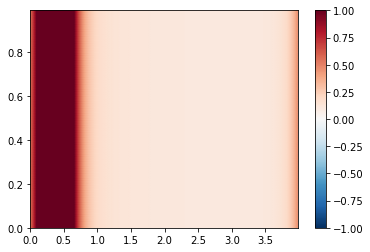

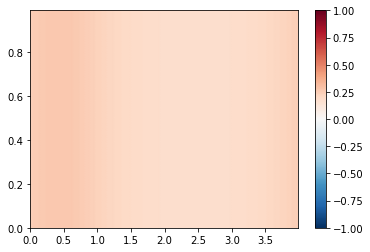

In [130]:
plt.pcolormesh(y.ravel(), x.ravel(), a_list[40], cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.colorbar()
plt.show()
plt.pcolormesh(y.ravel(), x.ravel(),b_list[-1],cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.colorbar()

2022-04-23 19:13:56,684 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


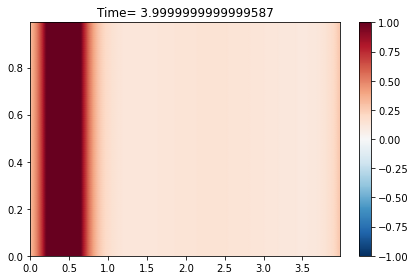

In [131]:
fig, ax = plt.subplots() 
def init():
    plt.pcolormesh(y.ravel(), x.ravel(),a_list[0],cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
    plt.colorbar()
    ax.set_title(f'Naive SI, t={t_list[0]}')
def update(i):
    plt.clf()
    plt.pcolormesh(y.ravel(), x.ravel(),a_list[i],cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
    plt.colorbar()
    plt.title(f'Time= {t_list[i]}')
    plt.tight_layout()


ani = FuncAnimation(fig, update, range(0,len(t_list)), init_func=init)
writer = PillowWriter(fps=15)
ani.save(f"snakes_dedalus_cell_density_alpha_{alpha}_r_{r}_periodic_bc.gif", writer=writer)

2022-04-23 19:14:18,190 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


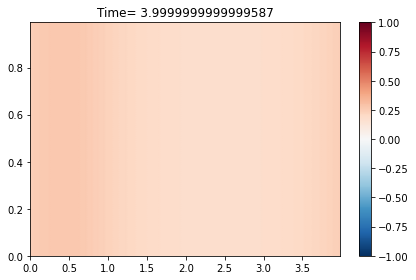

In [132]:
fig, ax = plt.subplots() 
def init():
    plt.pcolormesh(y.ravel(), x.ravel(),b_list[0],cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
    plt.colorbar()
    #ax.set_title(f'Naive SI, t={t_list[0]}')
def update(i):
    plt.clf()
    plt.pcolormesh(y.ravel(), x.ravel(),b_list[i],cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
    plt.colorbar()
    plt.title(f'Time= {t_list[i]}')
    plt.tight_layout()

ani = FuncAnimation(fig, update, range(0,len(t_list)), init_func=init)
writer = PillowWriter(fps=15)
ani.save(f"snakes_dedalus_chemoattractant_alpha_{alpha}_r_{r}_periodic_bc.gif", writer=writer)

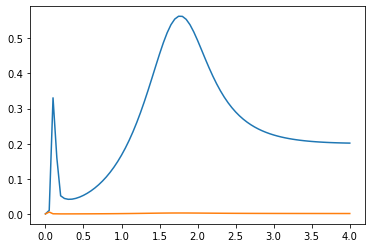

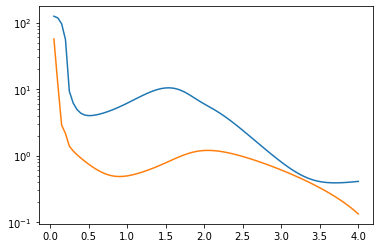

In [141]:
# convergence analysis
variance_a = [0]
variance_b = [0]
diff_a = []
diff_b = []
for j in range(len(t_list[1:])):
    variance_a.append(np.var(a_list[j]))
    variance_b.append(np.var(b_list[j]))
    diff_a.append(np.linalg.norm(a_list[j]-a_list[j-1]))
    diff_b.append(np.linalg.norm(b_list[j]-b_list[j-1]))
plt.plot(t_list, variance_a)
plt.plot(t_list, variance_b)
plt.show()
plt.semilogy(t_list[1:], diff_a)
plt.semilogy(t_list[1:], diff_b)